In [94]:
from sklearn.cluster import KMeans
from collections import OrderedDict
from sklearn import datasets, metrics
import numpy as np
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import Handout_MNIST.MNIST as mn


In [99]:
# in this cell you will have to add a suitable intialisation for the EM-algorithm to find good "clusters"
# note that "cluster" is a bit misleading, as only the degree of belonging to a distribution is evaluated 
# for each sample, and not an absolute assignment to a cluster is made

class EMClusters:

    def __init__(self):
        self.__numOfClasses = 0
        self.__numOfAttributes = 0

    # Initialises for EM to work
    # should be called with a suitable smoothing factor blur, but the default does at least something.
    def initialise(self, data, num_classes, num_attributes, blur=0.1):
        self.__blur = blur
        self.__data = data
        self.__numOfAttributes = num_attributes

        self.__numOfClasses = num_classes
        from sklearn.model_selection import KFold

        kf = KFold(shuffle = False, n_splits = 10)

        #self.__clusterMeansAndCovs = np.ones((self.__numOfClasses, self.__numOfAttributes, 2), dtype=float)
        #self.__priors = np.ones(self.__numOfClasses)
        
        self.__priors =  [0.05, 0.06, 0.07, 0.08, 0.09, 0.11, 0.12, 0.13, 0.14, 0.15]
        self.__clusterMeansAndCovs = np.ones((self.__numOfClasses, self.__numOfAttributes, 2), dtype=float)

        tempmeans = np.full((64, 10, 2),0)
        tempvariances = np.full((64, 10, 2),0)
        
        for i in range(10):
            data_temp = data.copy()
            np.random.shuffle(data_temp)
            data_temp = data_temp[:int(len(self.__data) / self.__numOfClasses)]
            data_temp = np.transpose(data_temp)
            for k, pixel in enumerate(data_temp):
                self.__clusterMeansAndCovs[i][k][0] = np.mean(pixel)
                self.__clusterMeansAndCovs[i][k][1] = np.var(pixel)
           
        # start of your code
        ###
        #
        # Here, you should now fill in something more sensible, as the code above is only a placeholder solution...
        # You need to find initial clusters and set start values for the priors, means and (co)variances that would
        # end up in the following arrays:
        #
        # self.__priors              - is of dimension K x 1 and holds K values, K the number of clusters / classes
        # self.__clusterMeansAndCovs - is of dimensions K x I x 2 and holds for each combination of class k
        #                              and attribute j the mean in [k, j, 0] and the covariance (only for jj,
        #                              as we assume conditional independence given the class) in [k, j, 1]
        #
        ###
        # end of your code

        
    # the actual EM algorithm, should be called with a suitable eps for a stop criterion
    # feel free to change (optimize) the implementation, but you do not have to do that
    def fit(self, eps=1.0):
        epsilon = eps

        print(self.__numOfAttributes)

        # print(self.__clusterMeansAndCovs[:,1,:])

        resp = np.zeros((len(self.__data), self.__numOfClasses))
        r_k = np.zeros(self.__numOfClasses)
        notDone = True
        while notDone:
            # print(self.__clusterMeansAndCovs)
            # E-step
            for i in range(len(self.__data)):
                probs = self.__priors.copy()
                for k in range(self.__numOfClasses):

                    for attr in range(self.__numOfAttributes):
                        probs[k] *= 1.0 / np.sqrt(
                            2 * math.pi * (self.__clusterMeansAndCovs[k, attr, 1] + self.__blur)) * math.exp(
                            -1.0 * math.pow((self.__clusterMeansAndCovs[k, attr, 0] - self.__data[i, attr]), 2) / (
                                        self.__clusterMeansAndCovs[k, attr, 1] + self.__blur))

                resp[i, :] = probs / sum(probs)
                # print(resp[i,:])
            
            # M-step
            newClusterMeansAndCovs = np.zeros((self.__numOfClasses, self.__numOfAttributes, 2))
            for k in range(self.__numOfClasses):
                r_k[k] = sum(resp[:, k])
                self.__priors[k] = 1 / len(self.__data) * r_k[k]

                for j in range(self.__numOfAttributes):
                    means = sum(resp[:, k] * self.__data[:, j]) / r_k[k]

                    newClusterMeansAndCovs[k, j, 0] = means
                    newClusterMeansAndCovs[k, j, 1] = sum(resp[:, k] * self.__data[:, j] * self.__data[:, j]) \
                                                      / r_k[k] - newClusterMeansAndCovs[k, j, 0] ** 2

            print(newClusterMeansAndCovs[:, :, 1])

            err = np.linalg.norm(self.__clusterMeansAndCovs[:, :, 0] - newClusterMeansAndCovs[:, :, 0])

            self.__clusterMeansAndCovs = newClusterMeansAndCovs.copy()
            print("err = " + str(err))
            if err <= epsilon:
                notDone = False
                
                
        # produce "clusters", i.e, assign the samples to "their" gaussian
        clustered = 10 * np.ones(len(self.__data), dtype=int)
        for i in range(len(self.__data)):
            probs = self.__priors.copy()
            for k in range(self.__numOfClasses):

                for attr in range(self.__numOfAttributes):
                    probs[k] *= 1.0 / np.sqrt(2 * math.pi * (self.__clusterMeansAndCovs[k, attr, 1] + self.__blur)) \
                                * math.exp(
                        -1.0 * math.pow((self.__clusterMeansAndCovs[k, attr, 0] - self.__data[i, attr]), 2) \
                        / (self.__clusterMeansAndCovs[k, attr, 1] + self.__blur))

            sumProb = np.sum(probs)
            if (sumProb > 0.0):
                probs = probs / sumProb
                clustered[i] = np.argmax(probs)

        return clustered, self.__clusterMeansAndCovs

    # prediction uses the found gaussians to compute the likelihoods in a GNBC
    def predict(self, samples):
        predicted = [None for i in range(len(samples))]
        prob = [[self.__priors[cls] for cls in range(self.__numOfClasses)] for i in range(len(samples))]
        # print(prob)
        for i in range(len(samples)):
            for cls in range(self.__numOfClasses):
                for attr in range(self.__numOfAttributes):
                    (mean, var) = (
                    self.__clusterMeansAndCovs[cls, attr, 0], self.__clusterMeansAndCovs[cls, attr, 1] + self.__blur)
                    # print( mean, var)
                    prob[i][cls] *= 1.0 / np.sqrt(2 * math.pi * var) * math.exp(
                        -1.0 * math.pow((mean - samples[i, attr]), 2) / var)
                # print(i, cls, prob[i][cls])

            sumProb = np.sum(prob[i])
            if (sumProb > 0.0):
                prob[i] = prob[i] / sumProb
                predicted[i] = np.argmax(prob[i])
            else:
                predicted[i] = 10

            # print(prob[i])

        return predicted

In [100]:
# use this to rearrange the outcome of a clustering to match the order of the classes in the training data
# note that this is only something to make it easier for you to inspect the results, but probably not a method
# you want to integrate in a final system

def correctClusters( confM, classes) :
    clusterMapping = -1 * np.ones_like(classes)
    for k in classes:
        temp = list(confM[:, k])
        #print(temp)
        notDone = True
        while notDone:
            amax = np.argmax(temp)
            if (confM[amax, k] == np.max(confM[amax, :])):
                clusterMapping[k] = amax
                notDone = False
            elif (sum(temp) == 0):
                notDone = False
            else:
                temp[amax] = 0

    for k in classes:
        if (clusterMapping[k] == -1):
            for j in classes:
                if j not in clusterMapping:
                    clusterMapping[k] = j

    return clusterMapping


In [101]:
# loading the digits data and normalising to values between 0 and 1

digits = datasets.load_digits()


num_examples = len(digits.data)
num_split = int(0.7 * num_examples)
train_features = 1/16. * digits.data[:num_split]
train_labels = digits.target[:num_split]
test_features = 1/16. *digits.data[num_split:]
test_labels = digits.target[num_split:]

num_attributes = 64

num_classes = 10

# alternatively, loading the MNIST_Light data, which is normalised in the get_data() method already
# OBS: this will take a while to run!

#mnist = mn.MNISTData('Handout_MNIST/MNIST_Light/*/*.png')
#train_features, test_features, train_labels, test_labels = mnist.get_data()
#num_attributes = 400
#num_classes = 10

64
[[0.00000000e+00 2.03902640e-03 8.95641853e-02 1.09011189e-01
  6.44702116e-02 9.86776770e-02 1.34708967e-02 3.55105214e-04
  1.06345965e-05 3.81681541e-02 1.43030652e-01 7.77847036e-02
  7.54662931e-02 1.40998639e-01 2.46952954e-02 4.73701714e-04
  8.57567743e-06 4.48212887e-02 1.30256345e-01 1.45299564e-01
  1.34062574e-01 1.27843160e-01 2.75534712e-02 3.02354897e-04
  2.43054425e-06 3.05726230e-02 1.51799826e-01 1.32245104e-01
  1.21946607e-01 1.26013833e-01 3.96072176e-02 3.68894350e-06
  0.00000000e+00 3.87654095e-02 1.59869244e-01 1.49241478e-01
  1.23763670e-01 1.37128672e-01 4.50189983e-02 0.00000000e+00
  6.14911870e-05 3.17848409e-02 1.62571020e-01 1.70265645e-01
  1.61649775e-01 1.32322905e-01 7.81732133e-02 1.63504900e-04
  1.60451883e-04 1.01635393e-02 1.16096353e-01 1.15993653e-01
  1.20732182e-01 1.34329344e-01 1.06006961e-01 5.54146843e-03
  2.44471309e-06 1.89936730e-03 1.03597929e-01 1.08329066e-01
  7.99404190e-02 1.38270761e-01 9.94925790e-02 1.76739807e-02]
 [0.

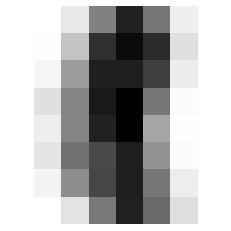

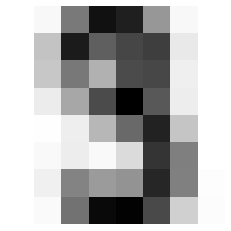

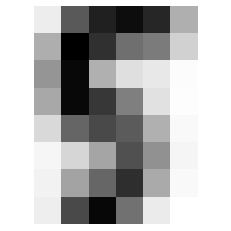

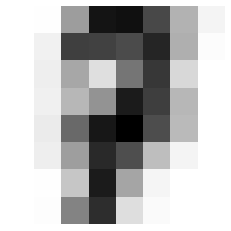

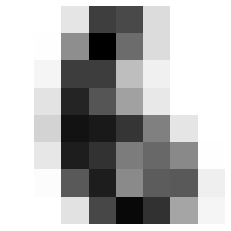

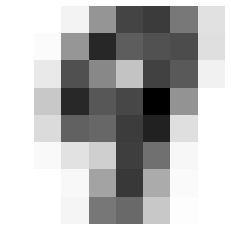

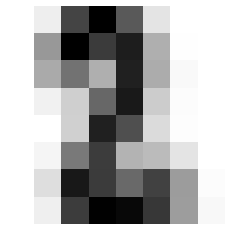

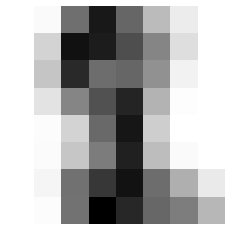

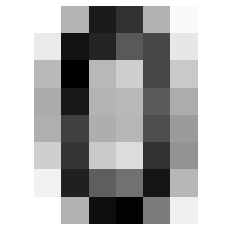

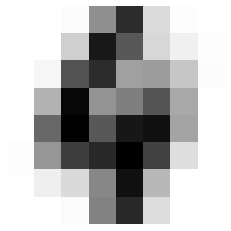

In [103]:
# some dummy call to the EM implementation, here you will have to change things (add parameters, for example)

emClusters = EMClusters()
emClusters.initialise(train_features, num_classes, num_attributes)
clustered, clusterMeansVars = emClusters.fit()

completeness_score = metrics.completeness_score(train_labels, clustered)
homogeneity_score = metrics.homogeneity_score(train_labels, clustered)
mutual_info_score = metrics.adjusted_mutual_info_score(train_labels, clustered)
print( "Completeness, homogeneity, adj mutual info EM vs labels", completeness_score, homogeneity_score, mutual_info_score)


for index, center in enumerate(clusterMeansVars[:,:,0]):
    img = center.reshape(8, 8)
    plt.figure()
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r)
    plt.show()
    


In [ ]:
# In this cell you should add the k-Means clustering to be able to compare to what you got with EM
# If you apply "correctClusters" from above (works with any confusion matrix), you can even test the results 
# against your or SKLearn's results in a classification attempt.

5. Because the completeness is 1 and homogeneity is 0, this means that all data points are part of the same cluster, i.e. all data points from a class belong to the same cluster(good completeness), but the cluster contains all different data point classes(bad homogeneity).